# Available Bluebikes Predictor

My hobby project to predict the number of available bluebikes in 3 stations near my home using historical trip data and weather data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
import os
from trip_data import get_data

## Extract and Process Data

### Blue Bike Trip Data

Trip data consists of all Bluebike trips from Jan. 2024 to Feb. 2025.

In [2]:
# init data and download trip data csv files

data_path = './trip_data'

# trip data range, currently using Jan 2024 to 2025 Jan
start_year = 2024
end_year = 2025
start_month = 1
end_month = 2
start_date = datetime(start_year, start_month, 1)
end_date = datetime(end_year, end_month, 1)
current_date = start_date

# init variables
station_ids = ['A32012', 'E32016', 'D32035']
time_interval = "60min"

# weather csv filename
weather_csv = f"{start_date.strftime('%Y%m%d')}-{datetime(end_date.year, end_month+1, 1).strftime('%Y%m%d')}-weather-data.csv"

In [11]:
get_data.get_weather_data(start_year, start_month, end_year, end_month+1, data_path)

Downloaded weather data: ./trip_data/20240101-20250301-weather-data.csv


In [12]:
get_data.get_bluebikes_trip_data(start_year,start_month,end_year,end_month,data_path)

https://s3.amazonaws.com/hubway-data/202401-bluebikes-tripdata.zip
Downloading: https://s3.amazonaws.com/hubway-data/202401-bluebikes-tripdata.zip
Extracted: 202401-bluebikes-tripdata.csv to ./trip_data
https://s3.amazonaws.com/hubway-data/202402-bluebikes-tripdata.zip
Downloading: https://s3.amazonaws.com/hubway-data/202402-bluebikes-tripdata.zip
Extracted: 202402-bluebikes-tripdata.csv to ./trip_data
https://s3.amazonaws.com/hubway-data/202403-bluebikes-tripdata.zip
Downloading: https://s3.amazonaws.com/hubway-data/202403-bluebikes-tripdata.zip
Extracted: 202403-bluebikes-tripdata.csv to ./trip_data
https://s3.amazonaws.com/hubway-data/202404-bluebikes-tripdata.zip
Downloading: https://s3.amazonaws.com/hubway-data/202404-bluebikes-tripdata.zip
Extracted: 202404-bluebikes-tripdata.csv to ./trip_data
https://s3.amazonaws.com/hubway-data/202405-bluebikes-tripdata.zip
Downloading: https://s3.amazonaws.com/hubway-data/202405-bluebikes-tripdata.zip
Extracted: 202405-bluebikes-tripdata.csv 

### Weather Data

In [6]:
weather_df = pd.read_csv(data_path + '/' + weather_csv, skiprows=2)

# rename columns
weather_df = weather_df.rename(columns={
    'temperature_2m (°C)': 'temperature',
    'precipitation (mm)': 'precipitation',
})


# convert time to datetime
weather_df['time'] = pd.to_datetime(weather_df['time'])

# interpolate weather data to intervals
weather_df_interpolated = weather_df.set_index('time').resample(time_interval).interpolate(method="nearest")
# round temperature to int
weather_df_interpolated['temperature'] = weather_df_interpolated['temperature'].round(0)


# reset index
weather_df_interpolated = weather_df_interpolated.reset_index()

# drop end_month, 1, 2025 data
weather_df_interpolated = weather_df_interpolated[weather_df_interpolated['time'].dt.date != datetime(2025, end_month+1, 1).date()]


weather_df_interpolated.tail()

,time,temperature,precipitation
10195,2025-02-28 19:00:00,1.0,0.0
10196,2025-02-28 20:00:00,1.0,0.0
10197,2025-02-28 21:00:00,2.0,0.0
10198,2025-02-28 22:00:00,1.0,0.0
10199,2025-02-28 23:00:00,1.0,0.0


Quick Visualization of Weather

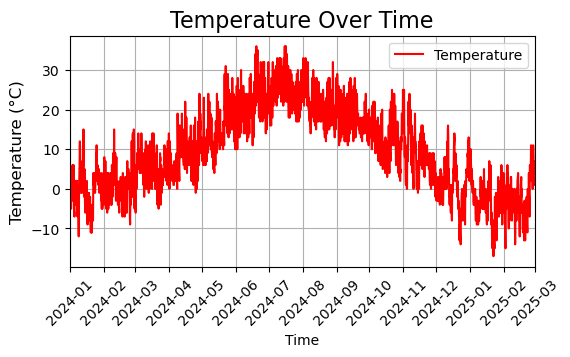

In [7]:
# Plot temperature over time
plt.figure(figsize=(6, 3))
sns.lineplot(x='time', y='temperature', data=weather_df_interpolated, color='red', label='Temperature')
plt.title('Temperature Over Time', fontsize=16)
plt.xlabel('Time', fontsize=10)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.xticks(rotation=45)
plt.xlim(start_date, datetime(end_year, end_month+1,1))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.legend()
plt.grid(visible=True)
plt.show()

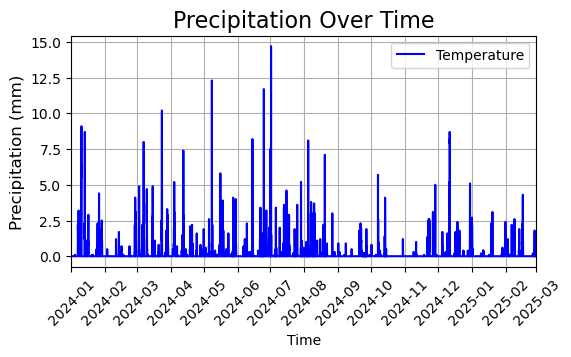

In [8]:
# Plot temperature over time
plt.figure(figsize=(6, 3))
sns.lineplot(x='time', y='precipitation', data=weather_df_interpolated, color='blue', label='Temperature')
plt.title('Precipitation Over Time', fontsize=16)
plt.xlabel('Time', fontsize=10)
plt.ylabel('Precipitation (mm)', fontsize=12)
plt.xticks(rotation=45)
plt.xlim(start_date, datetime(end_year, end_month+1,1))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.legend()
plt.grid(visible=True)
plt.show()

## Filter Trip Data

Load and combine trip CSVs into one dataframe

In [9]:
# combine all trip data into one dataframe
data_frames = []

current_date = start_date

while current_date <= end_date:
    file = f"{current_date.strftime('%Y%m')}-bluebikes-tripdata.csv"
    file_path = os.path.join(data_path, file)
    df = pd.read_csv(file_path)
    data_frames.append(df)

    if current_date.month == 12:
            current_date = datetime(current_date.year + 1, 1, 1)
    else:
        current_date = datetime(current_date.year, current_date.month + 1, 1)

trip_data_df = pd.concat(data_frames, ignore_index=True)

Filter trips to only include stations near my home

In [10]:
# bluebike stations near me
# "A32012" : "Packard's Corner - Commonwealth Ave at Brighton Ave",
# "E32016" : "Commonwealth Ave at Naples Rd",
# "D32035" : "Harvard Ave at Brainerd Rd",
stations_of_interest = ["A32012", "E32016", "D32035"]
stations_docks = {
    "A32012" : 26,
    "E32016" : 19,
    "D32035" : 19
}

# filter trips that start or end at my stations
filtered_trip_data = trip_data_df[trip_data_df['start_station_id'].isin(stations_of_interest) | trip_data_df['end_station_id'].isin(stations_of_interest)].copy()

In [11]:
# remove milliseconds from start and end time
filtered_trip_data.loc[:, 'started_at'] = filtered_trip_data.started_at.str[:16]
filtered_trip_data.loc[:, 'ended_at'] = filtered_trip_data.ended_at.str[:16]

In [12]:
# convert start and end time to datetime
filtered_trip_data['started_at'] = pd.to_datetime(filtered_trip_data.loc[:,'started_at'])
filtered_trip_data['ended_at'] = pd.to_datetime(filtered_trip_data.loc[:,'ended_at'])

# sort by start time
filtered_trip_data.sort_values('started_at', inplace=True)

# remove rideable_type, member_casual columns
filtered_trip_data.drop('rideable_type', axis=1, inplace=True)
filtered_trip_data.drop('member_casual', axis=1, inplace=True)
filtered_trip_data.drop('ride_id', axis=1, inplace=True)


filtered_trip_data.tail()

,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng
4935837,2025-02-28 22:51:00,2025-02-28 23:01:00,B.U. Central - 725 Comm. Ave.,A32003,Packard's Corner - Commonwealth Ave at Brighto...,A32012,42.350406,-71.108279,42.352261,-71.123831
4939651,2025-02-28 23:17:00,2025-02-28 23:22:00,Harvard St and Stedman St,K32017,Harvard Ave at Brainerd Rd,D32035,42.344352,-71.124904,42.349530,-71.130228
4935925,2025-02-28 23:19:00,2025-02-28 23:32:00,MIT Carleton St at Amherst St,M32070,Packard's Corner - Commonwealth Ave at Brighto...,A32012,42.360542,-71.086698,42.352261,-71.123831
4935750,2025-02-28 23:43:00,2025-02-28 23:50:00,Silber Way,D32032,Packard's Corner - Commonwealth Ave at Brighto...,A32012,42.349496,-71.100576,42.352261,-71.123831
4917890,2025-02-28 23:47:00,2025-02-28 23:54:00,Commonwealth Ave at Naples Rd,E32016,Silber Way,D32032,42.351911,-71.123798,42.349496,-71.100576


## Aggregate Data

My approach is to calculate the departures and arrivals for each station in 15 minute intervals.

### Initialize Dataframe with Time Intervals and Temporal Features

In [13]:
# create df w/ intervals
end_day = 28 if end_month == 2 else 30 if end_month in [4, 6, 9, 11] else 31
start_time = datetime(2024, 1, 1, 0, 0)
end_time = datetime(2025, end_month, end_day, 23, 45)
time_range = pd.date_range(start=start_time, end=end_time, freq=time_interval)

base_df = pd.DataFrame([(time, station) for time in time_range for station in station_ids],
                       columns=["time", "station_id"])

# temporal features
base_df["hour"] = base_df["time"].dt.hour
base_df["minute"] = base_df["time"].dt.minute
base_df["day_of_week"] = base_df["time"].dt.dayofweek  # Mon=0, Tues=1,...,Sun=6
base_df["month"] = base_df["time"].dt.month
base_df["year"] = base_df["time"].dt.year

base_df.head(12)

,time,station_id,hour,minute,day_of_week,month,year
0,2024-01-01 00:00:00,A32012,0,0,0,1,2024
1,2024-01-01 00:00:00,E32016,0,0,0,1,2024
2,2024-01-01 00:00:00,D32035,0,0,0,1,2024
3,2024-01-01 01:00:00,A32012,1,0,0,1,2024
4,2024-01-01 01:00:00,E32016,1,0,0,1,2024
5,2024-01-01 01:00:00,D32035,1,0,0,1,2024
6,2024-01-01 02:00:00,A32012,2,0,0,1,2024
7,2024-01-01 02:00:00,E32016,2,0,0,1,2024
8,2024-01-01 02:00:00,D32035,2,0,0,1,2024
9,2024-01-01 03:00:00,A32012,3,0,0,1,2024


### Calculate departures and arrivals

For each station, I will calculate the number of departures and arrivals in every 15 minute interval.

In [14]:
# Round trip times to the nearest interval
filtered_trip_data["start_interval"] = filtered_trip_data["started_at"].dt.floor(time_interval)
filtered_trip_data["end_interval"] = filtered_trip_data["ended_at"].dt.floor(time_interval)

# Filter for the specified station IDs
stations_of_interest = ["A32012", "E32016", "D32035"]
filtered_departures = filtered_trip_data[filtered_trip_data["start_station_id"].isin(stations_of_interest)]
filtered_arrivals = filtered_trip_data[filtered_trip_data["end_station_id"].isin(stations_of_interest)]

# Count departures and arrivals for each station and interval
departures = (
    filtered_departures.groupby(["start_interval", "start_station_id"])
    .size()
    .reset_index(name="departures")
    .rename(columns={"start_interval": "time", "start_station_id": "station_id"})
)

arrivals = (
    filtered_arrivals.groupby(["end_interval", "end_station_id"])
    .size()
    .reset_index(name="arrivals")
    .rename(columns={"end_interval": "time", "end_station_id": "station_id"})
)

### Merge data

Merging departures, arrivals, temperature, precipitation, and temporal data

In [15]:
# Merge departures and arrivals with the base DataFrame
base_df = base_df.merge(departures, on=["time", "station_id"], how="left")
base_df = base_df.merge(arrivals, on=["time", "station_id"], how="left")

# Fill missing values with 0
base_df["departures"] = base_df["departures"].fillna(0).astype(int)
base_df["arrivals"] = base_df["arrivals"].fillna(0).astype(int)

# merge weather data with base_df
base_df = base_df.merge(weather_df_interpolated, on="time", how="left")

# create a total trips column
base_df['total_trips'] = base_df['departures'] + base_df['arrivals']

In [16]:
print(base_df.isnull().sum())

base_df.tail(6)

time             0
station_id       0
hour             0
minute           0
day_of_week      0
month            0
year             0
departures       0
arrivals         0
temperature      0
precipitation    0
total_trips      0
dtype: int64


,time,station_id,hour,minute,day_of_week,month,year,departures,arrivals,temperature,precipitation,total_trips
30594,2025-02-28 22:00:00,A32012,22,0,4,2,2025,0,0,1.0,0.0,0
30595,2025-02-28 22:00:00,E32016,22,0,4,2,2025,0,0,1.0,0.0,0
30596,2025-02-28 22:00:00,D32035,22,0,4,2,2025,2,2,1.0,0.0,4
30597,2025-02-28 23:00:00,A32012,23,0,4,2,2025,0,3,1.0,0.0,3
30598,2025-02-28 23:00:00,E32016,23,0,4,2,2025,1,0,1.0,0.0,1
30599,2025-02-28 23:00:00,D32035,23,0,4,2,2025,0,1,1.0,0.0,1


## Data Analysis

Below I will do some basic trip data inspection where I will looking through data like weather vs trip data, hour of the day vs day of week heatmap, etc.

### Analyzing Monthly Trips Pattern

As expected, most bike usage occurs in warmer seasons with more usage around June - October.

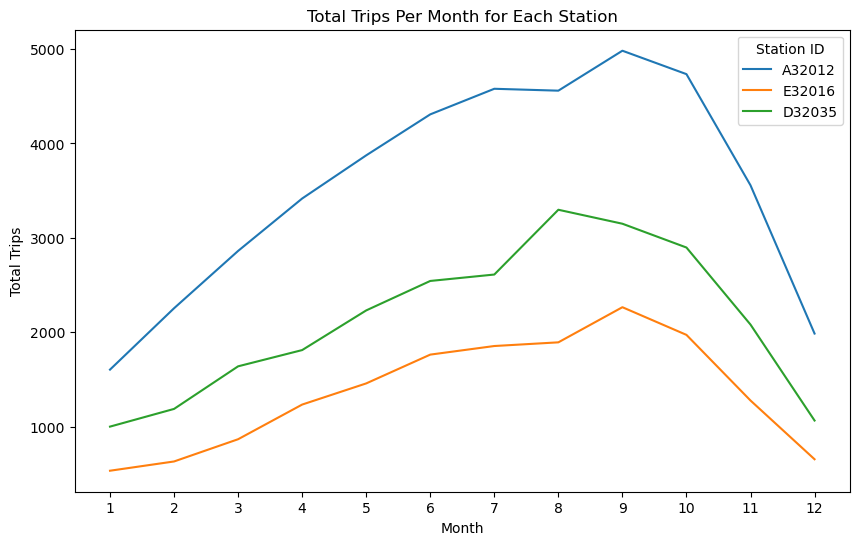

In [20]:
# Group by month and station, sum total trips by month and year first then get average total trips per month
monthly_trips = base_df.groupby(["year","month", "station_id"])["total_trips"].sum().reset_index().groupby(["month","station_id"])["total_trips"].mean().reset_index()

# Plot total trips per month for each station
plt.figure(figsize=(10, 6))
# sns.barplot(data=monthly_trips, x="month", y="total_trips", hue="station_id")
for station in station_ids:
    plt.plot(monthly_trips[monthly_trips["station_id"] == station]["month"], monthly_trips[monthly_trips["station_id"] == station]["total_trips"], label=station)
plt.title("Total Trips Per Month for Each Station")
plt.xlabel("Month")
plt.xticks(range(1, 13))
plt.ylabel("Total Trips")
plt.legend(title="Station ID")
plt.show()


### Anaylzing Popular Days of the Week for Trips

Not too much variance between different days of the week

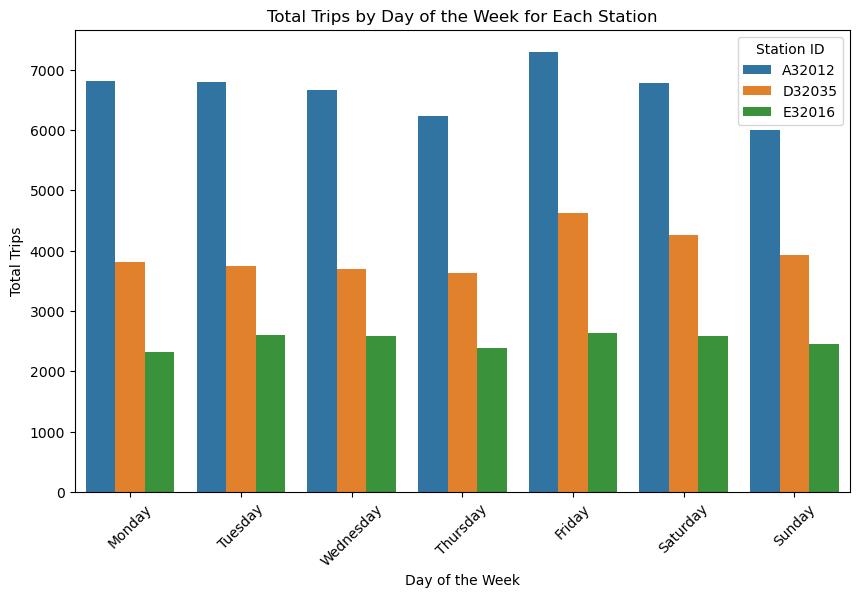

In [ ]:
# Group by day of the week and station
weekday_trips = base_df.groupby(["day_of_week", "station_id"])["total_trips"].sum().reset_index()

# Map day_of_week to names for better readability
weekday_mapping = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}
weekday_trips["day_of_week"] = weekday_trips["day_of_week"].map(weekday_mapping)

# Plot average trips by day of the week
plt.figure(figsize=(10, 6))
sns.barplot(data=weekday_trips, x="day_of_week", y="total_trips", hue="station_id")
plt.title("Total Trips by Day of the Week for Each Station")
plt.xlabel("Day of the Week")
plt.ylabel("Total Trips")
plt.legend(title="Station ID")
plt.xticks(rotation=45)
plt.show()

### Analyzing Popular Hours of the Day for Trips

As expected, most trips fall between 8 am to 8 pm. Most usage seems to be around 4-6 pm, which is in-line with what I see in real-life.

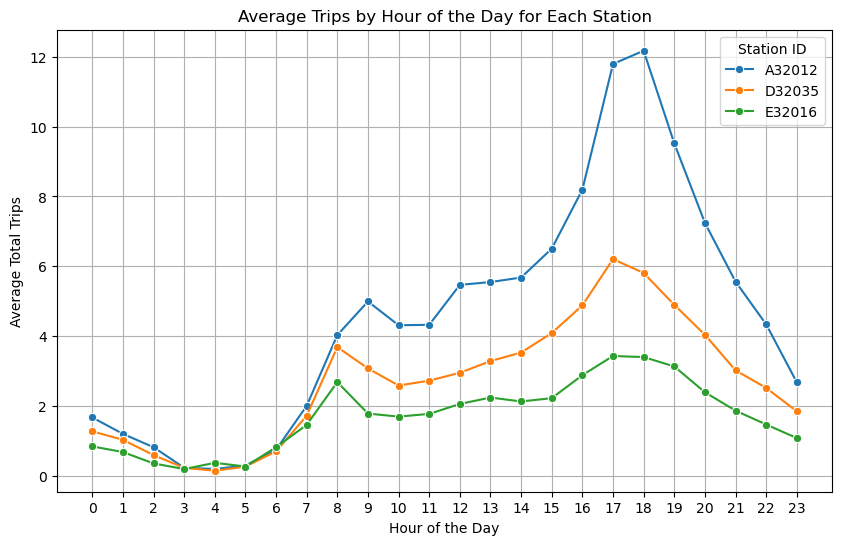

In [49]:
# Group by hour of the day and station
hourly_trips = base_df.groupby(["hour", "station_id"])["total_trips"].mean().reset_index()

# Plot average trips by hour of the day
plt.figure(figsize=(10, 6))
sns.lineplot(data=hourly_trips, x="hour", y="total_trips", hue="station_id", marker="o")
plt.title("Average Trips by Hour of the Day for Each Station")
plt.xlabel("Hour of the Day")
plt.xticks(range(0, 24))
plt.ylabel("Average Total Trips")
plt.legend(title="Station ID")
plt.grid()
plt.show()

Graphed over the week, it follows a cyclical pattern, which perhaps I can take advantage of in my prediction model.

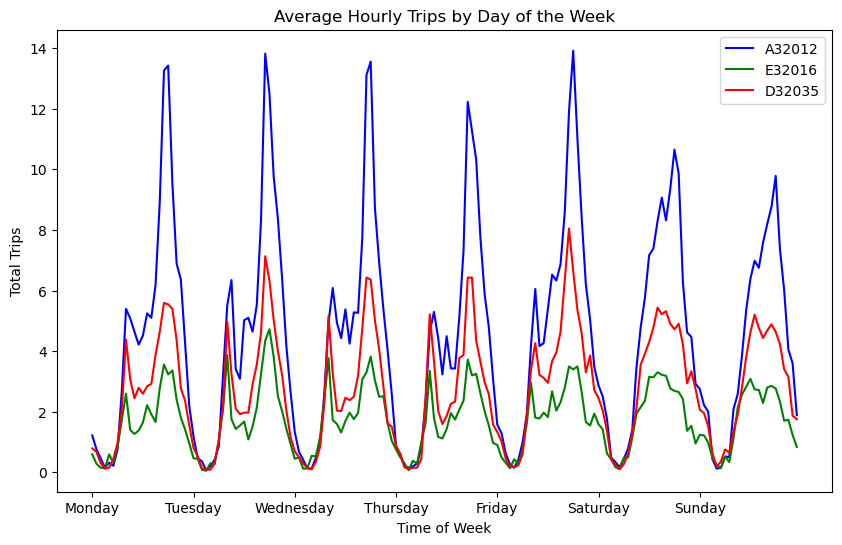

In [50]:
# plot average hourly demand for the week for each station
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title(f"Average Hourly Trips by Day of the Week")
ax.set_ylabel("Total Trips")
for idx, station_id in enumerate(station_ids):
    hour_week_trips = base_df[base_df["station_id"]==station_id].groupby(["station_id", "day_of_week", "hour"])["total_trips"].mean()
    hour_week_trips.plot(ax=ax, color="bgr"[idx])
    ax.legend(station_ids)
    ax.set_xticks(range(0, 24*7, 24))
    ax.set_xticklabels(weekday_mapping.values())
    ax.set_xlabel("Time of Week")





### Analyzing Temperature vs Total Trips Relationship

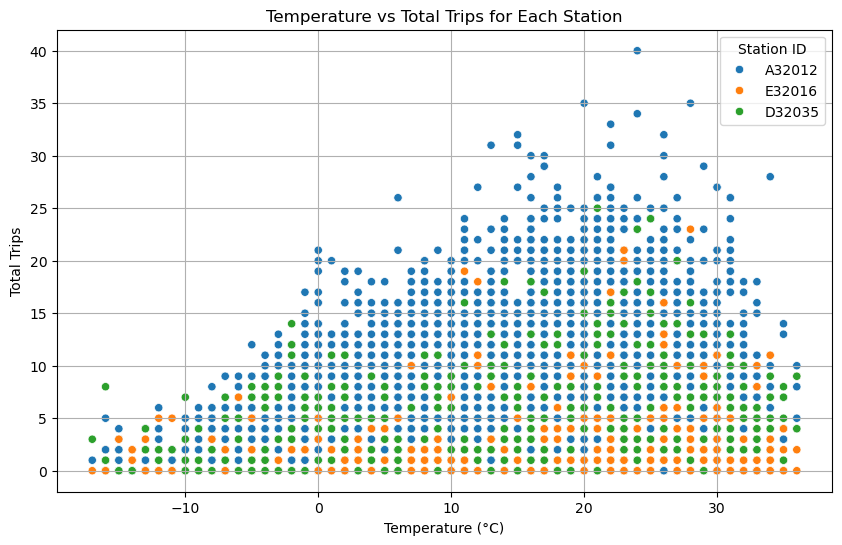

In [68]:
# Plot temperature vs total trips for each station
plt.figure(figsize=(10, 6))
sns.scatterplot(data=base_df, x="temperature", y="total_trips", hue="station_id")
# sns.lineplot(data=base_df, x="temperature", y="total_trips", hue="station_id", marker="o")
plt.title("Temperature vs Total Trips for Each Station")
plt.xlabel("Temperature (°C)")
plt.ylabel("Total Trips")
plt.legend(title="Station ID")
plt.grid()
plt.show()

<Axes: title={'center': 'Temperature vs Average Total Trips'}, xlabel='Temperature (°C)', ylabel='Average Total Trips'>

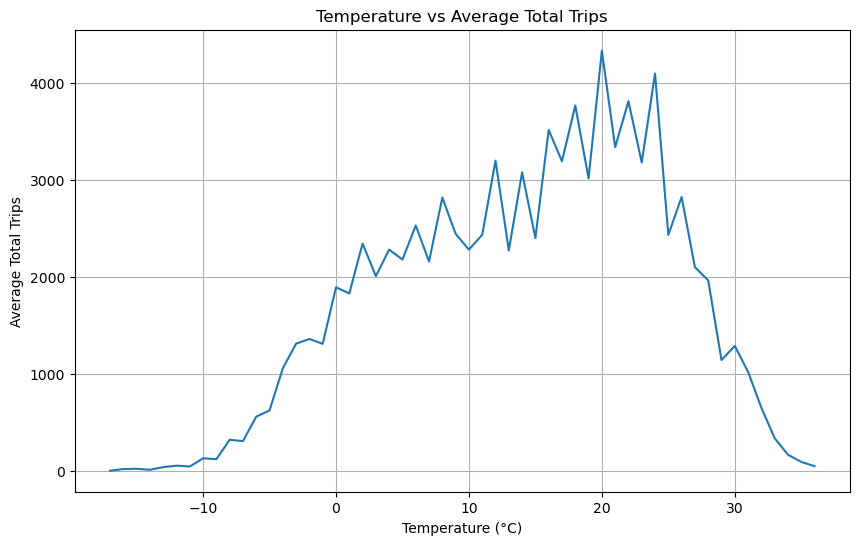

In [69]:
fig, ax = plt.subplots(figsize=(10, 6))
base_df.groupby(["temperature"])["total_trips"].sum().reset_index().plot(ax=ax,x="temperature", y="total_trips", title="Temperature vs Average Total Trips", legend=False, ylabel="Average Total Trips", xlabel="Temperature (°C)", grid=True)

### Analyzing Precipitation vs Total Trips Relationship

As expected, there are generally more trips with lower precipitation.

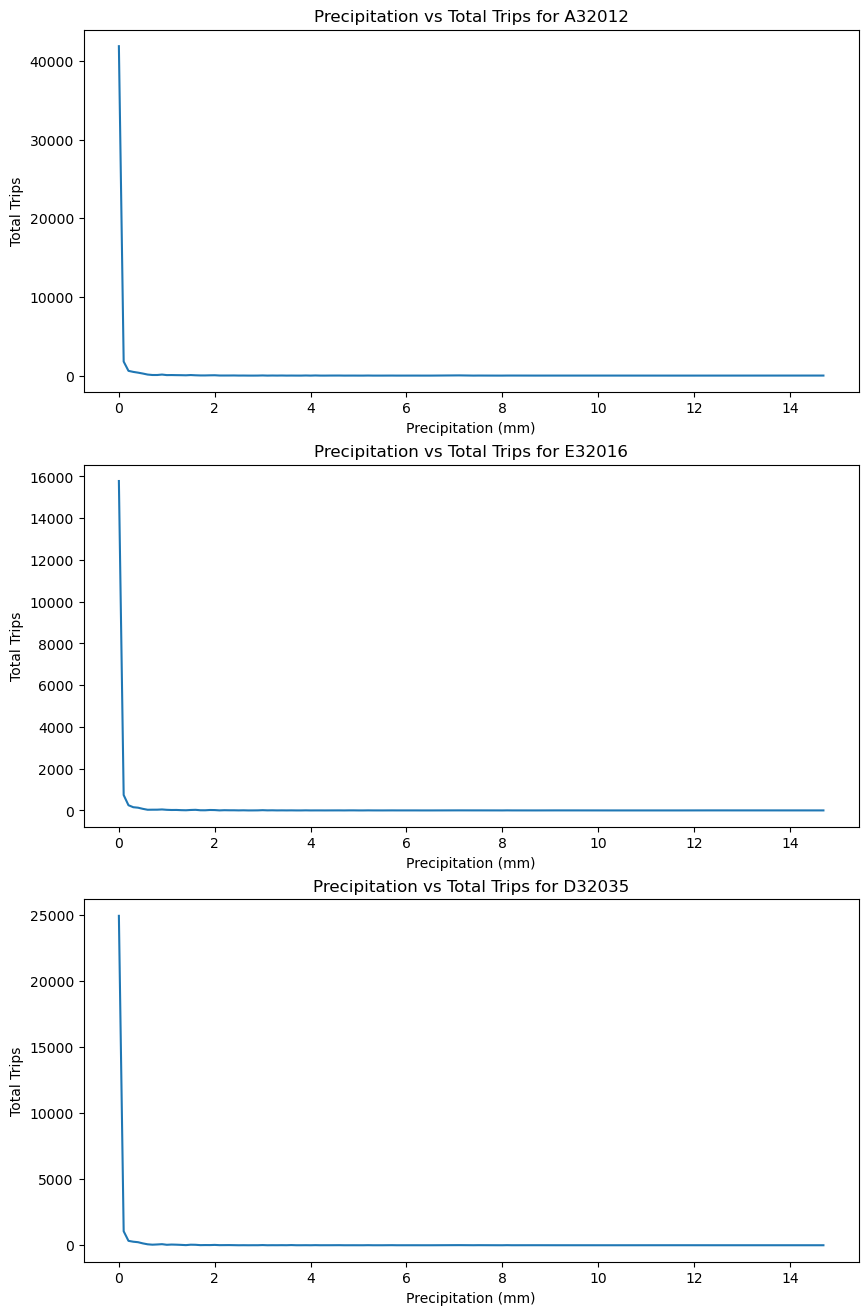

In [141]:
# Plot precipitation vs total trips for each station
fig, ax = plt.subplots(3,1, figsize=(10, 16))

for idx, station in enumerate(station_ids):
    precipitation_trips = base_df[base_df["station_id"]==station].groupby(["precipitation"])["total_trips"].sum().reset_index()
    sns.lineplot(data=precipitation_trips, x="precipitation", y="total_trips", ax=ax[idx])
    ax[idx].set_title(f"Precipitation vs Total Trips for {station}")
    ax[idx].set_xlabel("Precipitation (mm)")
    ax[idx].set_ylabel("Total Trips")

## Adding Categorical Features

## Prediction Models

In [85]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [86]:
# split data by station
station_data = {station_id: base_df[base_df["station_id"] == station_id] for station_id in station_ids}

# initialize time series split, used for gradient boosting models
tscv = TimeSeriesSplit(
    n_splits=5,
    gap=96
)

In [87]:
def evaluation_metrics(y_pred_deperatures, y_pred_arrivals, y_true_departures, y_true_arrivals):
    """
    Calculate evaluation metrics for the model
    """
    # Calculate MAE
    mae_departures = mean_absolute_error(y_true_departures, y_pred_deperatures)
    mae_arrivals = mean_absolute_error(y_true_arrivals, y_pred_arrivals)

    # Calculate RMSE
    rmse_departures = np.sqrt(root_mean_squared_error(y_true_departures, y_pred_deperatures))
    rmse_arrivals = np.sqrt(root_mean_squared_error(y_true_arrivals, y_pred_arrivals))

    # Calculate R^2
    r2_departures = r2_score(y_true_departures, y_pred_deperatures)
    r2_arrivals = r2_score(y_true_arrivals, y_pred_arrivals)

    print(f"Departures - MAE: {mae_departures:.2f}, RMSE: {rmse_departures:.2f}, R^2: {r2_departures:.2f}")
    print(f"Arrivals - MAE: {mae_arrivals:.2f}, RMSE: {rmse_arrivals:.2f}, R^2: {r2_arrivals:.2f}")

    return mae_departures, mae_arrivals, rmse_departures, rmse_arrivals, r2_departures, r2_arrivals

def evaluate(model, X, y, cv, model_prop=None, model_step=None):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
        return_estimator=model_prop is not None,
    )
    if model_prop is not None:
        if model_step is not None:
            values = [
                getattr(m[model_step], model_prop) for m in cv_results["estimator"]
            ]
        else:
            values = [getattr(m, model_prop) for m in cv_results["estimator"]]
        print(f"Mean model.{model_prop} = {np.mean(values)}")
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

### Model 1: Linear Model

I'll use a basic linear regression to act as my baseline model. Realistically this should perform poorly as many of the features do not have a linear relationship (eg. temperature vs bike rides are not linear).

In [91]:
linear_models = {}

for station_id, data in station_data.items():
    print(f"Training linear regression model for station {station_id}")
    X = data[["temperature", "precipitation", "hour", "day_of_week", "month"]]
    y_departures = data["departures"]
    y_arrivals = data["arrivals"]

    # train-test split
    X_train, X_test, y_train_dep, y_test_dep = train_test_split(X, y_departures, test_size=0.2, random_state=42)
    _, _, y_train_arrivals, y_test_arrivals = train_test_split(X, y_arrivals, test_size=0.2, random_state=42)

    # train linear regression model
    lr_arrivals = LinearRegression()
    lr_departures = LinearRegression()

    lr_departures.fit(X_train, y_train_dep)
    lr_arrivals.fit(X_train, y_train_arrivals)

    # save model
    linear_models[station_id] = {"departures": lr_departures, "arrivals": lr_arrivals}

    # make predictions, calculate metrics
    y_pred_dep = lr_departures.predict(X_test)
    y_pred_arrivals = lr_arrivals.predict(X_test)

    curr_metrics = evaluation_metrics(y_pred_dep, y_pred_arrivals, y_test_dep, y_test_arrivals)
    print()


Training linear regression model for station A32012
Departures - MAE: 1.63, RMSE: 1.48, R^2: 0.25
Arrivals - MAE: 1.74, RMSE: 1.57, R^2: 0.34

Training linear regression model for station E32016
Departures - MAE: 0.94, RMSE: 1.16, R^2: 0.12
Arrivals - MAE: 0.82, RMSE: 1.13, R^2: 0.19

Training linear regression model for station D32035
Departures - MAE: 1.20, RMSE: 1.30, R^2: 0.14
Arrivals - MAE: 1.15, RMSE: 1.26, R^2: 0.27

